<a href="https://colab.research.google.com/github/jk-math/Image-Recognition/blob/main/ASL_image_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import string
alphabet = list(string.ascii_lowercase)

In [2]:
# This dataset contains some actual image files
# data is not split into training and validation sets
path = '/content/drive/MyDrive/Colab Notebooks/ASL_MNIST/Dataset.zip'
z = zipfile.ZipFile(path, 'r')
z.extractall('/tmp')
z.close()

In [3]:
users = os.listdir('/tmp/Dataset')
print(users)

['user_10', 'user_5', 'user_4', 'user_6', 'user_9', 'user_3', 'user_7']


In [4]:
# image data stored in csv file
# each line is of the form label, pixel1, pixel2, ...

path = '/content/drive/MyDrive/Colab Notebooks/ASL_MNIST/asl_csv.zip'
z = zipfile.ZipFile(path, 'r')
z.extractall('/tmp')
z.close()

In [5]:
train_path = '/tmp/sign_mnist_train.csv'
valid_path = '/tmp/sign_mnist_test.csv'

train_labels = []
train_images = []

valid_labels = []
valid_images = []

def extract_data(path):
  images = []
  labels = []
  with open(path, 'r') as file:
    for line in file.readlines()[1:]: #first line contains headers label, pixel1, pixel2, ...
      pixel_values = line.split(',')
      pixel_values[-1] = pixel_values[-1].rstrip() # remove line break from last pixel value
      labels.append(int(pixel_values[0]))
      pixels = np.array([pixel_values[1:]], dtype = float)
      img = pixels.reshape(28,28) # reshape to get image
      images.append(img)
  return np.array(images), np.array(labels, dtype = int)


In [6]:
train_images, train_labels = extract_data(train_path)
valid_images, valid_labels = extract_data(valid_path)

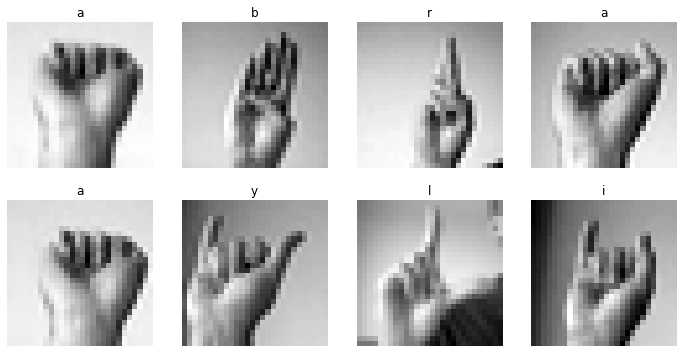

In [7]:
# plot some random training images
fig, axs = plt.subplots(2,4)
fig.set_figwidth(12)
fig.set_figheight(6)
for i in range(2):
  for j in range(4):
    for k in random.sample(range(len(train_images)), 8):
      axs[i,j].imshow(train_images[k], cmap = 'gray')
      axs[i,j].axis('off')
      axs[i,j].set_title('{}'.format(alphabet[int(train_labels[k])]))

In [8]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [9]:
cnn_model = tf.keras.models.Sequential([
                                        Conv2D(16, (3,3), input_shape = (28,28,1), activation = 'relu'),
                                        MaxPooling2D(2,2),
                                        Conv2D(32, (3,3), activation = 'relu'),
                                        MaxPooling2D(2,2),
                                        Flatten(),
                                        Dropout(0.2),
                                        Dense(128, activation = 'relu'),
                                        Dropout(0.5),
                                        Dense(26, activation = 'softmax')
])

cnn_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_images = np.expand_dims(train_images, axis = -1)
valid_images = np.expand_dims(valid_images, axis = -1)


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.1,
                                   shear_range = 0.05)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
cnn_history = cnn_model.fit(train_datagen.flow(x = train_images, y = train_labels, batch_size = 32),
                            epochs = 10,
                            validation_data = valid_datagen.flow(x = valid_images, y = valid_labels, batch_size = 32))

Epoch 1/10
858/858 [==============================] - 16s 16ms/step - loss: 2.7580 - accuracy: 0.1724 - val_loss: 0.8980 - val_accuracy: 0.7172
Epoch 2/10
858/858 [==============================] - 14s 16ms/step - loss: 1.2835 - accuracy: 0.5845 - val_loss: 0.4814 - val_accuracy: 0.8618
Epoch 3/10
858/858 [==============================] - 14s 16ms/step - loss: 0.9474 - accuracy: 0.6804 - val_loss: 0.3363 - val_accuracy: 0.9095
Epoch 4/10
858/858 [==============================] - 14s 16ms/step - loss: 0.7871 - accuracy: 0.7287 - val_loss: 0.2260 - val_accuracy: 0.9485
Epoch 5/10
858/858 [==============================] - 14s 16ms/step - loss: 0.6678 - accuracy: 0.7717 - val_loss: 0.2007 - val_accuracy: 0.9598
Epoch 6/10
858/858 [==============================] - 14s 16ms/step - loss: 0.5776 - accuracy: 0.7983 - val_loss: 0.1454 - val_accuracy: 0.9689
Epoch 7/10
858/858 [==============================] - 14s 16ms/step - loss: 0.5250 - accuracy: 0.8236 - val_loss: 0.1227 - val_accuracy:

In [13]:
def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs = range(len(acc))

  plt.figure(figsize = (5,5))

  plt.plot(epochs, acc, label = 'Training Acc', color = 'green')
  plt.plot(epochs, val_acc, label = 'Validation Acc', color = 'purple')
  plt.legend(loc = 'lower right')
  plt.title('Training vs. Validation Accuracy')

  plt.show()
  plt.close()

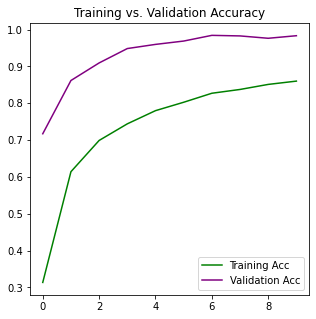

In [14]:
plot_acc(cnn_history)

In [15]:
# plot some random images and the output from passing these images through a particular set of filters in the conv and pool layers
def visualize_activation(model, images, conv_num):
  outputs = [layer.output for layer in model.layers]
  # layer_names = [layer.name for layer in model.layers]
  visualize = tf.keras.models.Model(inputs = model.input, outputs = outputs)

  idxs = random.sample(range(2000), 5)

  fig, axs = plt.subplots(5,5) # 5 random images, plot original image and the four activation layers before Flatten

  fig.set_figwidth(15)
  fig.set_figheight(10)

  for i, idx in enumerate(idxs):
    axs[i,0].imshow(images[idx].reshape(28,28), cmap = 'gray')
    axs[i,0].axis('off')
    img = np.expand_dims(images[idx], axis = 0)
    activations = visualize.predict(img)
    for x in range(4): # in total, only 4 conv or pool layers before the Flatten and Dense layers
      activation = activations[x]
      axs[i,x+1].imshow(activation[0, : , :, conv_num], cmap='inferno')
      axs[i,x+1].axis('off')

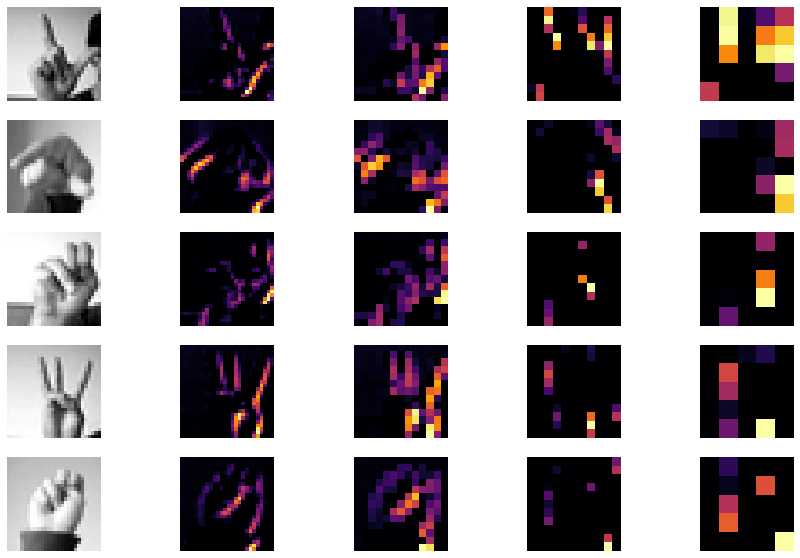

In [21]:
visualize_activation(cnn_model, train_images, 9)

In [17]:
def viz_activation(model, images):
  outputs = [layer.output for layer in model.layers]
  layer_names = [layer.name for layer in model.layers]

  viz = tf.keras.models.Model(inputs = model.input, outputs = outputs)

  idx = random.randint(0,2400) # random int to select random image 

  img = np.expand_dims(train_images[idx] / 255, axis = 0)

  activations = viz.predict(tf.constant(img))

  for layer_name, activation in zip(layer_names[:4], activations[:4]):
    n_filters = activation.shape[-1] # number of filters in the layer
    output_size = activation.shape[1] # size of output after it goes through layer
    # set up grid of zeros - image passed through layer results in output_size*n_filters different outputs
    layer_activation = np.zeros(shape = (output_size, output_size*n_filters)) 
    for i in range(n_filters):
      A = activation[0, : , : , i]
      max = A.max()
      min = A.min()
      if max != min:
        A = (A - A.min()) / (A.max() - A.min()) # min-max scale the activation for each filter
      layer_activation[:, i*output_size: (i+1)*output_size] = A
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.title(layer_name)
    plt.imshow(layer_activation, cmap = 'inferno')

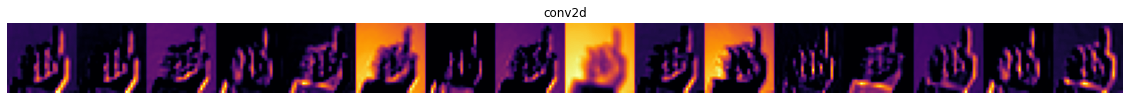

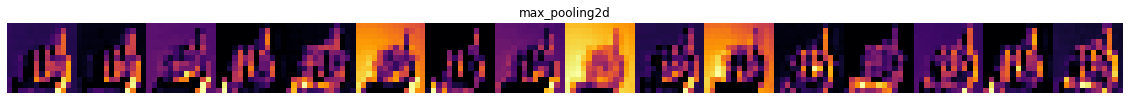

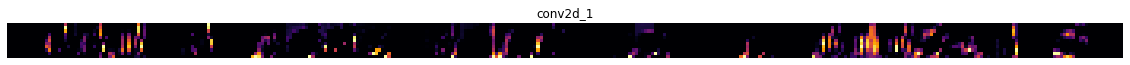

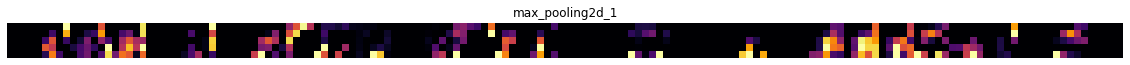

In [24]:
viz_activation(cnn_model, train_images)